In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
import QuantLib as ql
import model_settings
import modin.pandas as md
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_database_indexing import keys_df, symbol, h5_name,dates
from historical_av_plot_vol_surface import plot_vol_surface
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()

available dates:
0       2024-10-17
1       2024-10-16
2       2024-10-15
3       2024-10-14
4       2024-10-11
           ...    
1257    2019-10-17
1258    2019-10-16
1259    2019-10-15
1260    2019-10-14
1261    2019-10-11
Length: 1262, dtype: object
Index(['raw_data', 'spot_price', 'surface', 'date'], dtype='object')


# data

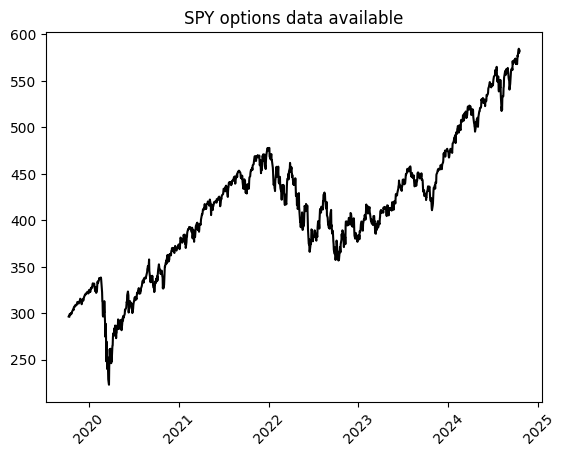

<Figure size 640x480 with 0 Axes>

In [2]:
datetimes = pd.to_datetime(dates)
spots = pd.Series(np.zeros(len(datetimes),dtype=float),index=datetimes)
while True:
    try:
        store.open()
        for i,row in keys_df.iterrows():
            key = row['spot_price']
            date = key[key.find('_',0)+1:key.find('/',1)]
            spot_datetime = datetime.strptime(date,'%Y_%m_%d')
            spot_price = store[key].iloc[0]
            spots.loc[spot_datetime] = spot_price
        break
    except OSError as e:
        time.sleep(2)
    finally:
        store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# calibrations

In [3]:
keys_df

,raw_data,spot_price,surface,date
0,/date_2024_10_17/raw_data,/date_2024_10_17/spot_price,/date_2024_10_17/surface,2024-10-17
1,/date_2024_10_16/raw_data,/date_2024_10_16/spot_price,/date_2024_10_16/surface,2024-10-16
2,/date_2024_10_15/raw_data,/date_2024_10_15/spot_price,/date_2024_10_15/surface,2024-10-15
3,/date_2024_10_14/raw_data,/date_2024_10_14/spot_price,/date_2024_10_14/surface,2024-10-14
4,/date_2024_10_11/raw_data,/date_2024_10_11/spot_price,/date_2024_10_11/surface,2024-10-11
...,...,...,...,...
1257,/date_2019_10_17/raw_data,/date_2019_10_17/spot_price,/date_2019_10_17/surface,2019-10-17
1258,/date_2019_10_16/raw_data,/date_2019_10_16/spot_price,/date_2019_10_16/surface,2019-10-16
1259,/date_2019_10_15/raw_data,/date_2019_10_15/spot_price,/date_2019_10_15/surface,2019-10-15
1260,/date_2019_10_14/raw_data,/date_2019_10_14/spot_price,/date_2019_10_14/surface,2019-10-14


In [4]:
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in keys_df.dropna(subset=['calibration_results']).iterrows():
            key = row['calibration_results']
            date = key[key.find('_',0)+1:key.find('/',1)].replace('_','-')
            calibrations.append(store[row['calibration_results']])
            parameters[date] = store[row['heston_parameters']]
        break
    except OSError as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date').sort_index()
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

KeyError: ['calibration_results']

## calibration testing

### original recalibration

In [ ]:
problem_parameter = 'theta'
problem_theshold = 99999
problems = pd.Series(calibrations[problem_parameter][calibrations[problem_parameter]>problem_theshold].drop_duplicates().index).dt.strftime('/date_%Y_%m_%d/heston_calibration/calibration_results')
dfs = {}
with pd.HDFStore(h5_name) as store:
    for key in problems:
        dfs[key] = store[key]
store.close()
print('problem calibration(s):')
for i,dfk in enumerate(dfs.keys()):
    print(f"{i}     {dfk}")
problem_keys = keys_df[keys_df['calibration_results'].isin(problems)]

In [ ]:
problem_idx = 0
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    with pd.HDFStore(h5_name) as store:
        calibration_results = problem_keys['calibration_results'].iloc[0]
        surface = store[problem_keys['surface'].iloc[problem_idx]].drop_duplicates()
        heston_parameters = store[problem_keys['heston_parameters'].iloc[problem_idx]]
        calibration = store[problem_keys['calibration_results'].iloc[problem_idx]]
        raw_data = store[problem_keys['raw_data'].iloc[problem_idx]]
        problem_spot = float(store[problem_keys['spot_price'].iloc[problem_idx]].iloc[0])
        date = calibration_results[calibration_results.find('_',0)+1:calibration_results.find('/',1)].replace('_','-')
        
    store.close()
    print(date)
    previous_avgabs = np.mean(np.abs(calibration['error']))
    print("original calibration:")
    plot_vol_surface(surface)
    print(heston_parameters)
    calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
    calculation_date = ql.Date(
        calculation_datetime.day,
        calculation_datetime.month,
        calculation_datetime.year
    )
    printdate = str(calculation_datetime.strftime('%A, ')+str(calculation_date))
    print(f"average absolute relative error: {round(100*previous_avgabs,4)}%")
    print(printdate)

### cleaning original raw data

In [ ]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    spot = problem_spot
    df = raw_data.copy()
    df['volume'] = pd.to_numeric(df['volume'])
    df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
    df['strike'] = pd.to_numeric(df['strike'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['days_to_maturity'] = df['expiration'] - df['date']
    df['days_to_maturity'] = df['days_to_maturity'] // np.timedelta64(1, 'D')
    df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
    df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
    df = df[['strike','implied_volatility','days_to_maturity','volume','type']]
    df = df[df['volume']>0].copy()
    df['spot_price'] = spot
    df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
    df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
    df = df.rename(
        columns={
            'strike':'strike_price',
            'type':'w',
            'implied_volatility':'volatility'
        }
    )
    
    indexed = df.copy().set_index(['strike_price','days_to_maturity'])

    
    T = np.sort(df['days_to_maturity'].unique()).tolist()
    K = np.sort(df['strike_price'].unique()).tolist()
    raw_surface = pd.DataFrame(
        np.tile(np.nan,(len(K),len(T))),
        index = K,
        columns = T
    )
    for k in K:
        for t in T:
            if (k, t) in indexed.index:
                raw_surface.loc[k, t] = indexed.loc[(k, t), 'volatility']
    auto_surface = raw_surface.dropna()
    vol_matrix = auto_surface

### manual recalibration

In [ ]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    s = spot
    T = vol_matrix.columns.tolist()
    K = vol_matrix.index.tolist()
    r = 0.04
    g = 0.0
    
    ql.Settings.instance().evaluationDate = calculation_date
    flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    
    heston_helpers = []
    v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
    process = ql.HestonProcess(
        flat_ts,
        dividend_ts,
        S_handle,
        v0,                # Initial volatility
        kappa,             # Mean reversion speed
        theta,             # Long-run variance (volatility squared)
        eta,               # Volatility of the volatility
        rho                # Correlation between asset and volatility
    )
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    
    for t in T:
        for k in K:
            p = ql.Period(int(t),ql.Days)
            volatility = vol_matrix.loc[k,t]
            helper = ql.HestonModelHelper(
                p, ms.calendar, float(s), k, 
                ql.QuoteHandle(ql.SimpleQuote(volatility)), 
                flat_ts, 
                dividend_ts
                )
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
    
    lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    
    
    model.calibrate(heston_helpers, lm,
                      ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
    
    theta, kappa, eta, rho, v0 = model.params()
    heston_parameters = pd.Series(
        [theta, kappa, eta, rho, v0],
        index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
        dtype = float
    )
    calibration_test_data = df.copy()
    calibration_test_data['spot_price'] = s
    calibration_test_data['risk_free_rate'] = r
    calibration_test_data['dividend_rate'] = g
    calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
    calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
    calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
        calibration_test_data['spot_price'].values,
        calibration_test_data['strike_price'].values,
        calibration_test_data['w'].values
    )
    calibration_test_data['calculation_date'] = date
    calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
    calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
    calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values/calibration_test_data['black_scholes'].values-1
    avg = np.mean(np.abs(calibration_test_data['error']))

    print("recalibrated:")
    plot_vol_surface(vol_matrix)
    print(f"\n{printdate}\n{heston_parameters}\n\naverage absolute error: {round(100*avg,4)}%")
    print(f"previous error: {round(100*previous_avgabs,4)}%\nchange: {round(100*(avg-previous_avgabs),4)}%")
    print(f"\n\ncalibration testing dataset:\n{calibration_test_data.describe()}")
    print(f"\n{calibration_test_data.dtypes}")

### ENTRY REPLACEMENT

In [5]:
def replace_calibration_data():
    results_replacement_key = problem_keys.iloc[problem_idx]['calibration_results']
    parameter_replacement_key = problem_keys.iloc[problem_idx]['heston_parameters']
    surface_replacement_key = problem_keys.iloc[problem_idx]['surface']
    with pd.HDFStore(h5_name) as store:
        store.put(surface_replacement_key,vol_matrix,format='table',append=False)
        store.put(parameter_replacement_key,heston_parameters,format='table',append=False)
        store.put(results_replacement_key,calibration_test_data,format='table',append=False)
        print(f'{results_replacement_key} | {parameter_replacement_key} | {surface_replacement_key}:     replaced')
    store.close()
try:
    print(printdate)
except Exception:
    pass

In [7]:
keys_df

,raw_data,spot_price,surface,date
0,/date_2024_10_17/raw_data,/date_2024_10_17/spot_price,/date_2024_10_17/surface,2024-10-17
1,/date_2024_10_16/raw_data,/date_2024_10_16/spot_price,/date_2024_10_16/surface,2024-10-16
2,/date_2024_10_15/raw_data,/date_2024_10_15/spot_price,/date_2024_10_15/surface,2024-10-15
3,/date_2024_10_14/raw_data,/date_2024_10_14/spot_price,/date_2024_10_14/surface,2024-10-14
4,/date_2024_10_11/raw_data,/date_2024_10_11/spot_price,/date_2024_10_11/surface,2024-10-11
...,...,...,...,...
1257,/date_2019_10_17/raw_data,/date_2019_10_17/spot_price,/date_2019_10_17/surface,2019-10-17
1258,/date_2019_10_16/raw_data,/date_2019_10_16/spot_price,/date_2019_10_16/surface,2019-10-16
1259,/date_2019_10_15/raw_data,/date_2019_10_15/spot_price,/date_2019_10_15/surface,2019-10-15
1260,/date_2019_10_14/raw_data,/date_2019_10_14/spot_price,/date_2019_10_14/surface,2019-10-14


In [64]:
from datetime import timedelta
from model_settings import ms

In [88]:
raw_data = pd.HDFStore(h5_name)['/date_2024_10_17/raw_data']
s = float(pd.HDFStore(h5_name)['/date_2024_10_17/spot_price'].iloc[0])
store.close()
raw_data['spot_price'] = s
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility'],errors='coerce').astype(float)
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities
float_columns = [
    'strike', 'last', 'mark','bid', 'ask', 'implied_volatility', 
    'delta', 'gamma', 'theta', 'vega', 'rho'
]
int_columns = ['bid_size','ask_size', 'volume', 'open_interest']
raw_data[int_columns] = raw_data[int_columns].astype(int)
raw_data[float_columns] = raw_data[float_columns].astype(float)
raw_data = raw_data[raw_data['days_to_maturity']>0].reset_index(drop=True)
raw_data['moneyness'] = ms.vmoneyness(raw_data['spot_price'],raw_data['strike'],raw_data['type'])
raw_data = raw_data[(raw_data['moneyness']<0)*(raw_data['moneyness']>=-0.5)]



raw_databy_t = raw_data.sort_values(by=['volume'],ascending=False).reset_index(drop=True).groupby('days_to_maturity')
T = np.sort(raw_data['days_to_maturity'].unique())
K = np.sort(raw_data['strike'].unique())

subset = raw_databy_t.get_group(T[0])
calls = subset[subset['type']=='call']
puts = subset[subset['type']=='put']
T

array([  1,   4,   5,   6,   7,   8,  11,  12,  13,  14,  15,  22,  29,
        36,  43,  64,  75,  92, 106, 134, 155, 165, 182, 246, 256, 302,
       337, 348, 428, 456, 609, 792, 820])